In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import warnings
import numpy as np
import pylab as plt

from skimage import morphology
from scipy.ndimage import binary_dilation

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian2DKernel, convolve

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ
from parabolas import loadLeicaData, fitParabola, parabola, fitLeicaData
from grid import regridXYZ, regridXYZMasked
from plotting import surfacePlot, barChartPlot, scatterPlot
from utils.utils import midPoint, radialMask, gridLimits, maskDiff
from zernikies import zernikeWLS, getZernikeCoeffs, zernikePoly, zernikeFitLS
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/dask/config.py:129: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
def prepareData(filename, n=512, rot=178.):
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    xg, yg, zg = regridXYZ(x, y, z, n=n)
    xg, yg, zg = shiftRotateXYZ(xg, yg, zg, [0, 0, 0, 0, 0, np.deg2rad(rot)])
    
    return xg, yg, zg

def maskLoop(diff):
    mask = maskDiff(diff, window=(20,20), threshold=2)
    mDiff = np.ma.masked_where(mask, diff)
    b = morphology.remove_small_holes(mDiff.mask, area_threshold=64)
    mDiff = np.ma.masked_where(b, mDiff)
    return mDiff

def maskData(diff):
    mDiff = maskLoop(diff)
    mDiff = np.ma.masked_outside(mDiff, -5e-3, 5e-3)
    mDiff = maskLoop(diff)
    return mDiff

In [38]:
n = 512
rot = 179.5
iters = 1
nZern = 36
iz = 4
izv = -167
zcoef = np.zeros(nZern)
zcoef[iz] = izv
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [39]:
%%time
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
#refScan = "{0}/2020_03_16_02:54:59.ptx.csv".format(scanDir)
#refScan = "{0}/2020_03_16_06:11:20.ptx.csv".format(scanDir)
xr, yr, zr = prepareData(refScan, n=n, rot=rot)

CPU times: user 6.54 s, sys: 1.27 s, total: 7.81 s
Wall time: 5.73 s


In [40]:
%%time
#sigScan = "{0}/2020_03_16_02:28:31.ptx.csv".format(scanDir) # C4=-518
#sigScan = "{0}/2020_03_16_03:02:51.ptx.csv".format(scanDir) # C4=-486
#sigScan = "{0}/2020_03_16_06:43:17.ptx.csv".format(scanDir) # C4=-562
sigScan = "{0}/2020_03_16_03:27:25.ptx.csv".format(scanDir) # C4=-167
#sigScan = "{0}/2020_03_16_02:21:06.ptx.csv".format(scanDir) # Ref scan
#sigScan = "{0}/2020_03_16_07:56:13.ptx.csv".format(scanDir) # C7=-554
xs, ys, zs = prepareData(sigScan, n=n, rot=rot)

CPU times: user 3.47 s, sys: 799 ms, total: 4.27 s
Wall time: 2.76 s


In [41]:
%%time
xmin, xmax = gridLimits(xs, xr)
ymin, ymax = gridLimits(ys, yr)
xrg, yrg, zrg = regridXYZ(xr, yr, zr, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
xsg, ysg, zsg = regridXYZ(xs, ys, zs, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

CPU times: user 1min 35s, sys: 1.98 s, total: 1min 37s
Wall time: 1min 34s


<IPython.core.display.Javascript object>


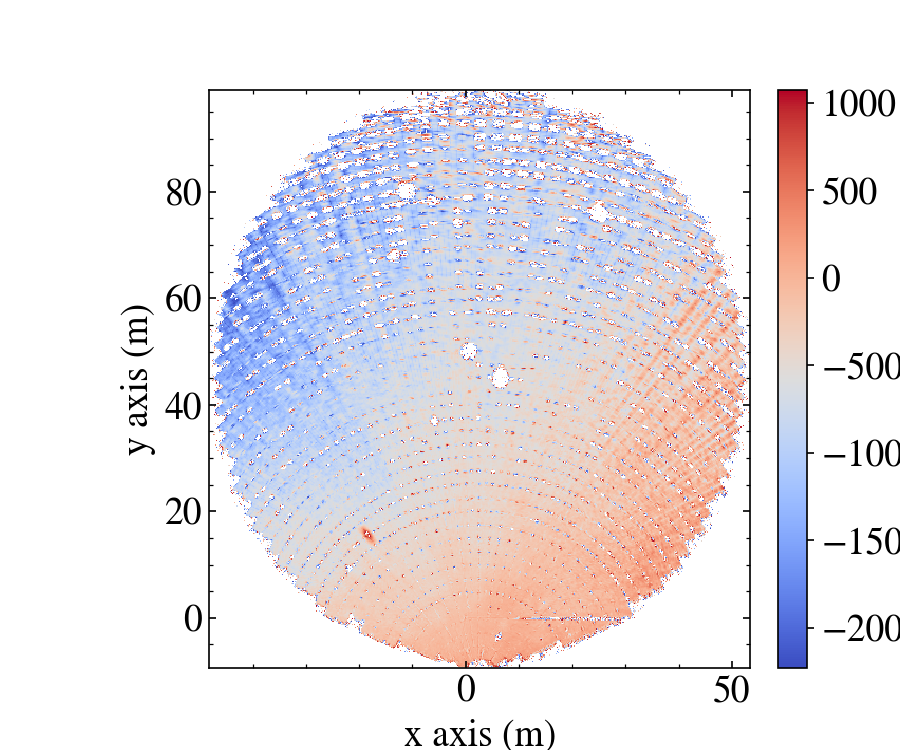

In [55]:
diff = np.ma.masked_invalid(zsg - zrg)
diff = sigma_clip(diff, 3)
vmin = np.nanmin(diff*1e6)
vmax = np.nanmax(diff*1e6)
surfacePlot(xrg, yrg, diff.T*1e6, vMin=vmin, vMax=vmax, midPoint=(vmin+vmax)*0.5)

<IPython.core.display.Javascript object>


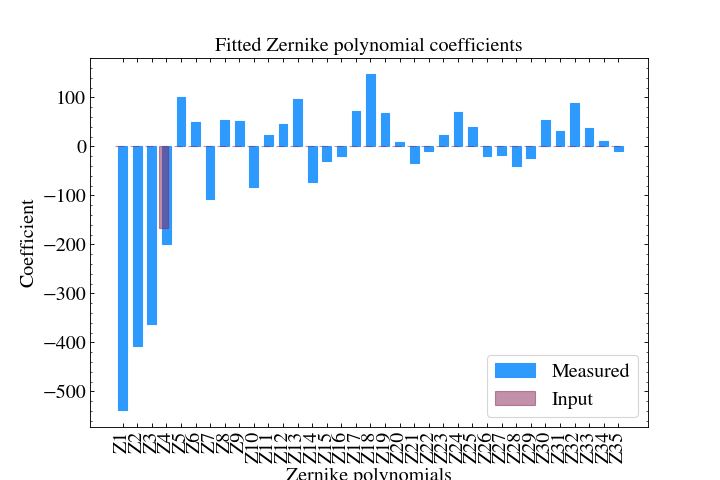

-199.50861123824075


In [52]:
fl_fs = getZernikeCoeffs(diff.filled(0)[::-1].T, 36, norm='active-surface')
barChartPlot(np.arange(1,36), fl_fs[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs[iz]*1e6)

Number of iterations: 2


<IPython.core.display.Javascript object>


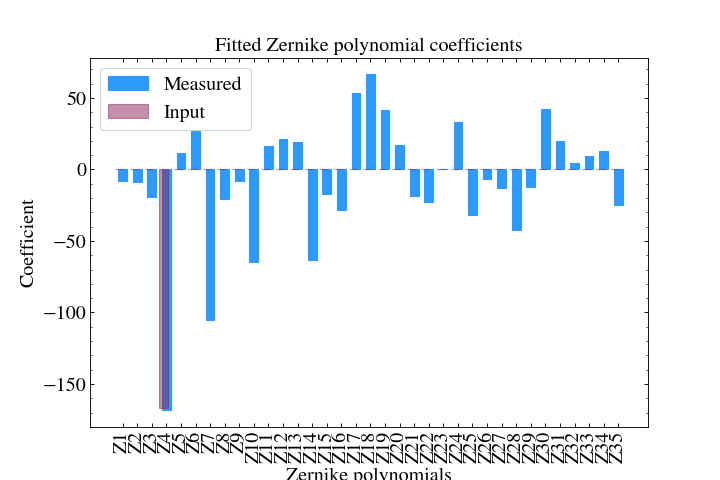

-168.49022224937278


<IPython.core.display.Javascript object>


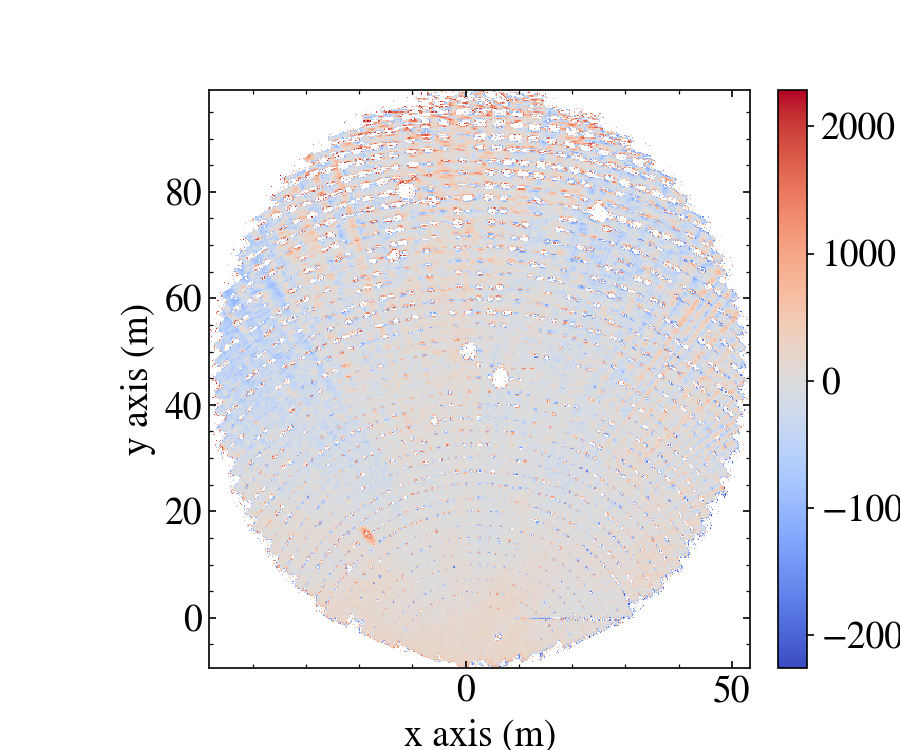

In [54]:
diff_ = np.ma.copy(diff)
fl_fs_sub = np.copy(fl_fs)
it = 0
while np.any(abs(fl_fs_sub[2:4]) > 50e-6):
    #fl_fs_sub[1] *= 0.
    fl_fs_sub[2] *= -1.
    zpoly_ = zernikePoly(xrg, yrg, midPoint(xrg), midPoint(yrg), fl_fs_sub[0:4])
    diff_ = diff_ - zpoly_
    fl_fs_sub = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
    it += 1
print("Number of iterations: {}".format(it))
barChartPlot(np.arange(1,36), fl_fs_sub[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs_sub[iz]*1e6)
surfacePlot(xrg, yrg, diff_.T*1e6, vMin=np.nanmin(diff_*1e6), vMax=np.nanmax(diff_*1e6))

In [56]:
np.sum(np.power(fl_fs_sub, 2.)), np.power(np.nanstd(diff_), 2.)

(6.93627901551051e-08, 1.4410615494065037e-07)